In [2]:
import pandas as pd
import numpy as np
from scipy import signal
from scipy.stats import entropy
from statsmodels.nonparametric.smoothers_lowess import lowess
from matplotlib import pyplot as plt
from matplotlib import dates
from datetime import datetime
import sys
%matplotlib inline
import ruptures as rpt
from ruptures.base import BaseCost
import matplotlib.patches as patches

In [141]:
def data_generator(ts_length = 400, points_to_skip = 48, random_seed = None, cp_prob = 1):
    if random_seed:
        np.random.seed(random_seed)
        
    signal = np.cos(2*np.pi/24 * np.arange(0, ts_length) + (np.pi/2))
    noise = np.random.normal(0,0.1,ts_length)
    signal = signal+noise

    change_point = np.random.choice(np.arange(points_to_skip,ts_length),1)[0]
    change_point = np.random.choice([0,change_point],1,p=[1-cp_prob,cp_prob])[0]
    change_point_value = np.random.normal(0.5,0.1,1)*np.random.choice([-1,1],1,)[0]
    
    if change_point != 0:
        signal[change_point:] = signal[change_point:]+change_point_value
    return([signal, change_point, change_point_value])

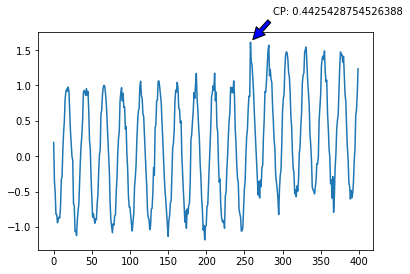

In [183]:
generated = data_generator()
plt.plot(generated[0])
plt.annotate('CP: {}'.format(generated[2][0]), xy=(generated[1], generated[0][generated[1]]), xytext=(generated[1]+30, 2), arrowprops=dict(facecolor='blue', shrink=0.1))
plt.show()
